In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/creditcard.csv")
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# **Data Preprocessing**
## 1. Check for Missing Values

In [2]:
print(df.isnull().sum())


Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


## 2. Understand Data Distribution
Check class imbalance:

In [3]:
print(df['Class'].value_counts(normalize=True))


Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


## 3. Feature Scaling

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])


# **Exploratory Data Analysis (EDA)**
## 1. Visualize Class Distribution

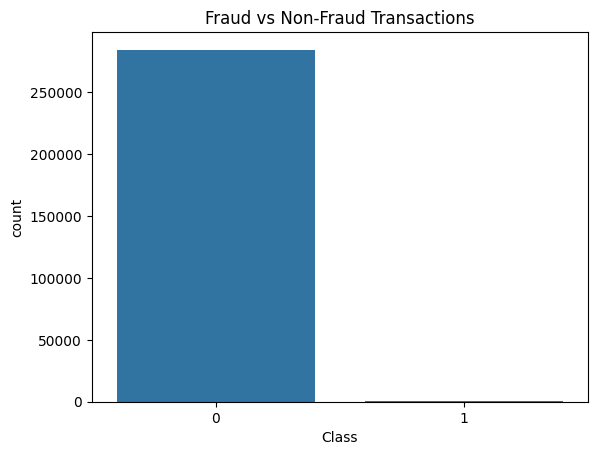

In [5]:
sns.countplot(x=df["Class"])
plt.title("Fraud vs Non-Fraud Transactions")
plt.show()


## 2. Correlation Heatmap

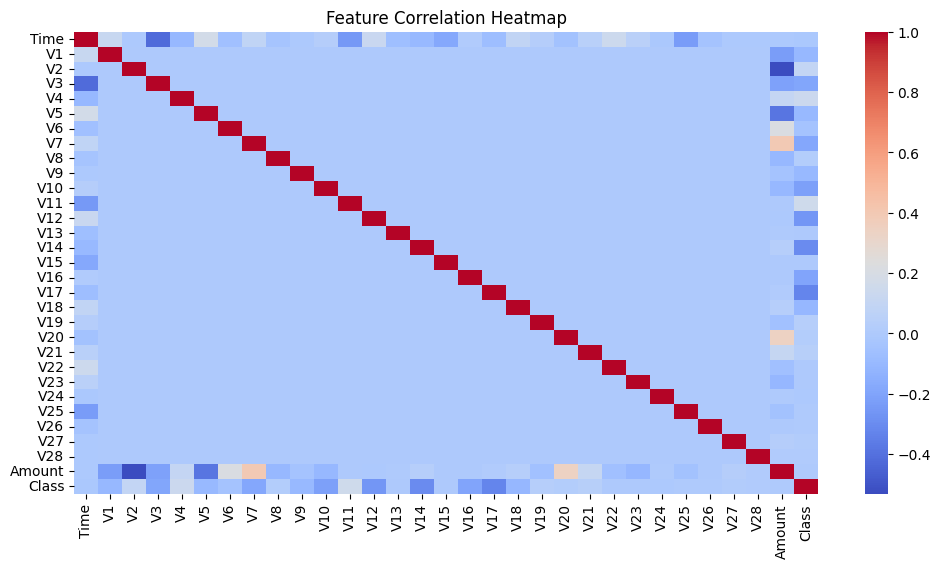

In [6]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


# **Data Splitting**
Since this is an unsupervised anomaly detection, we primarily train on non-fraudulent transactions.


In [7]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop(columns=['Class'])
y = df['Class']

# Train only on normal transactions (Class 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train[y_train == 0]  # Only normal transactions


# **Model Training**
## 1. Isolation Forest (Machine Learning)

In [8]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(n_estimators=200, contamination=0.0017, random_state=42)
iso_forest.fit(X_train)

# Predict anomalies (-1 for fraud, 1 for normal)
y_pred_iso = iso_forest.predict(X_test)
y_pred_iso = [1 if i == -1 else 0 for i in y_pred_iso]


# **2. Autoencoder (Deep Learning)**

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_dim = X_train.shape[1]

# Define input layer
input_layer = keras.Input(shape=(input_dim,))

# Encoder
encoded = layers.Dense(64, activation='relu')(input_layer)
encoded = layers.Dense(32, activation='relu')(encoded)
encoded = layers.Dense(16, activation='relu')(encoded)
encoded = layers.Dense(8, activation='relu')(encoded)

# Decoder
decoded = layers.Dense(16, activation='relu')(encoded)
decoded = layers.Dense(32, activation='relu')(decoded)
decoded = layers.Dense(64, activation='relu')(decoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)  # Reconstruction layer

# Build model
autoencoder = keras.Model(inputs=input_layer, outputs=decoded)

# Compile model
autoencoder.compile(optimizer='adam', loss='mse')

# Train model
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=256,
                          validation_data=(X_test, X_test),
                          verbose=1)



Epoch 1/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.9559 - val_loss: 0.8508
Epoch 2/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7968 - val_loss: 0.8124
Epoch 3/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7621 - val_loss: 0.7972
Epoch 4/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.7673 - val_loss: 0.7930
Epoch 5/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7645 - val_loss: 0.7872
Epoch 6/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7576 - val_loss: 0.7812
Epoch 7/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.7459 - val_loss: 0.7736
Epoch 8/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.7608 - val_loss: 0.7685
Epoch 9/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7543 - val_loss: 0.7659
Epoch 10/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7377 - val_loss: 0.7601
Epoch 11/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7286 - val_loss: 0.7582
Epoch 12/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

# **Model Evaluation**
## 1. Evaluate Isolation Forest

In [10]:
from sklearn.metrics import classification_report

print("Isolation Forest Report:\n", classification_report(y_test, y_pred_iso))


Isolation Forest Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.23      0.28      0.25        98

    accuracy                           1.00     56962
   macro avg       0.61      0.64      0.62     56962
weighted avg       1.00      1.00      1.00     56962



## 2. Evaluate Autoencoder


In [11]:
# Compute reconstruction error
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Set threshold for anomaly detection
threshold = np.percentile(mse, 99.83)  # Adjust as needed
y_pred_auto = [1 if e > threshold else 0 for e in mse]

print("Autoencoder Report:\n", classification_report(y_test, y_pred_auto))


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Autoencoder Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.26      0.26      0.26        98

    accuracy                           1.00     56962
   macro avg       0.63      0.63      0.63     56962
weighted avg       1.00      1.00      1.00     56962



# **Test XGBoost with SMOTE (Supervised Learning).**
## Apply SMOTE to Balance the Dataset

In [12]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Apply SMOTE to balance fraud and normal transactions
smote = SMOTE(sampling_strategy=0.01, random_state=42)  # 1% fraud cases
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split into training and test sets
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42)

# **Train XGBoost Model.**

In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Initialize and train XGBoost
xgb = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1,
                    subsample=0.8, colsample_bytree=0.8, random_state=42)

xgb.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred_xgb = xgb.predict(X_test_smote)

# Print classification report
print("XGBoost Report:\n", classification_report(y_test_smote, y_pred_xgb))


XGBoost Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56883
           1       0.99      0.93      0.96       549

    accuracy                           1.00     57432
   macro avg       1.00      0.96      0.98     57432
weighted avg       1.00      1.00      1.00     57432



# **Visualizing the Precision-Recall Curve for Model Comparison**
The Precision-Recall (PR) Curve helps assess how well each model detects fraud cases (Class 1).

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


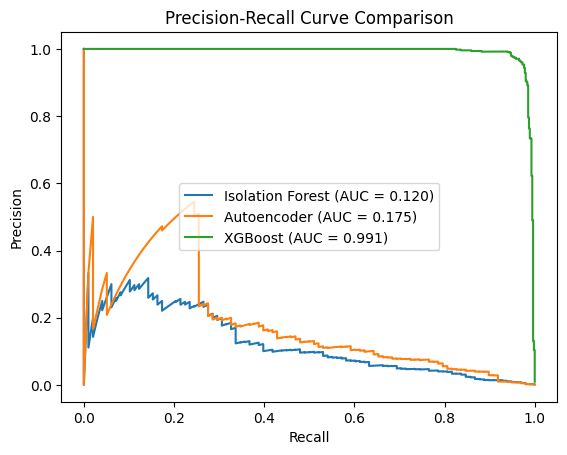

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Function to plot PR curve
def plot_pr_curve(y_true, y_scores, label):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{label} (AUC = {pr_auc:.3f})')

# Compute scores for Isolation Forest
iso_forest_scores = iso_forest.decision_function(X_test)  # Higher score = more normal
plot_pr_curve(y_test, -iso_forest_scores, "Isolation Forest")  # Invert scores

# Compute scores for Autoencoder (Reconstruction Error)
autoencoder_preds = autoencoder.predict(X_test)
autoencoder_errors = ((X_test - autoencoder_preds) ** 2).mean(axis=1)
plot_pr_curve(y_test, autoencoder_errors, "Autoencoder")

# Compute scores for XGBoost
xgb_probs = xgb.predict_proba(X_test_smote)[:, 1]  # Probability of fraud
plot_pr_curve(y_test_smote, xgb_probs, "XGBoost")

# Plot settings
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.show()


# **Understanding Feature Importance in XGBoost**
XGBoost provides built-in tools to analyze which features contribute the most to fraud detection. We can visualize feature importance using `XGBoost's feature_importances_` attribute and **SHAP values** for deeper insights.

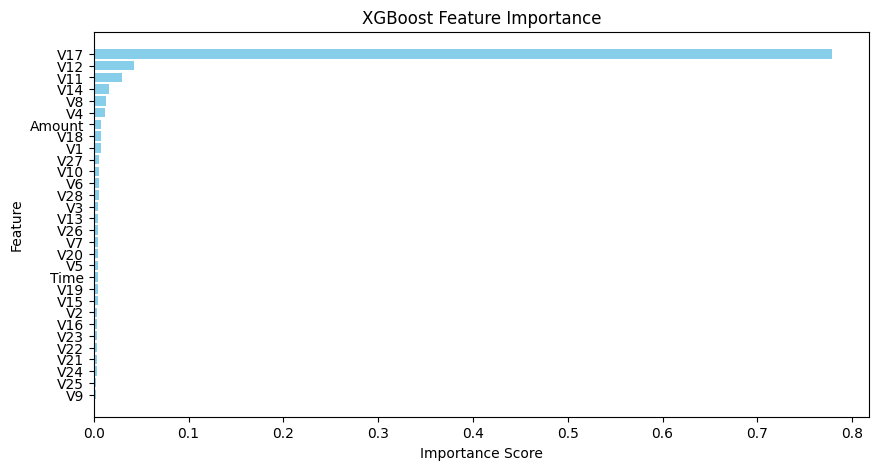

In [15]:
# Extract feature importance scores
feature_importance = xgb.feature_importances_

# Convert to DataFrame
feat_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort by importance
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(feat_importance_df['Feature'], feat_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()


## **Explain with SHAP (SHapley Additive exPlanations)**

100%|===================| 57427/57432 [09:52<00:00]       

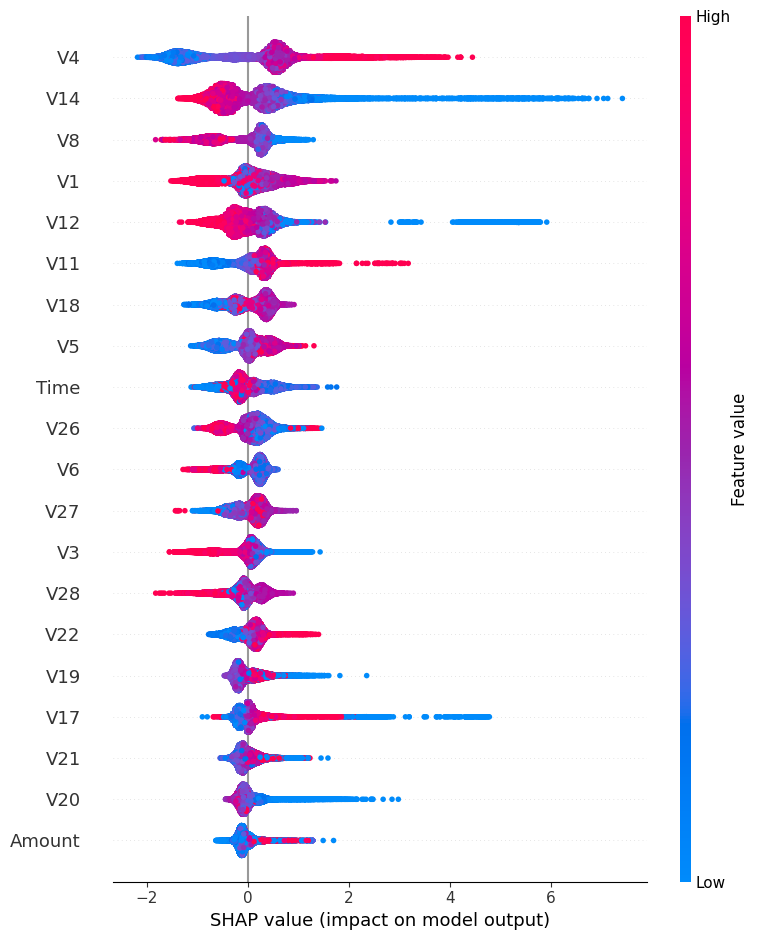

In [16]:
import shap

# Initialize SHAP explainer
explainer = shap.Explainer(xgb, X_test_smote)

# Compute SHAP values
shap_values = explainer(X_test_smote)

# Summary plot
shap.summary_plot(shap_values, X_test_smote)
